

The Discrete Fourier Transform (DFT) turns a data vector into a sum of sine/cosine components. The DFT is a Fourier series on data instead of analytic functions. Why do we perform the DFT? Because the features typically of interest aren't always obvious in the time domain. The Fast Fourier Transform (FFT) is an efficient method used to calculate the DFT. The naive implementation of DFT scales as $\mathcal{O}(n^2)$, whereas FFT scales as $\mathcal{O}(n \mathrm{log}(n))$.

Our original data is sampled at uniform intervals represented as $[f_{0}, f_{1}, \dots, f_{n}]^{T}$, and we want to obtain a vector of Fourier coefficients $[\hat{f}_{0}, \hat{f}_{1}, \dots, \hat{f}_{n}]^{T}$. In the second vector, $\hat{f}_{0}$ represents how much of the lowest frequency is in the data, $\hat{f}_{1}$ represents how much of the second lowest frequency, etc. The formula used to go from data to Fourier coefficients is given by:

$$
\hat{f}_{k} = \sum_{j=0}^{n-1} f_{j}e^{i 2\pi jk/n}.
$$

In words, the $k^{th}$ Fourier coefficient is obtained by taking the sum over all $j$ data points at the $j^{th}$ frequency times the $k^{th}$ frequency divided by $n$. We can see that this expression represents a sum of sin and cosine terms by recalling $e^{in} = \mathrm{cos}(n) + i\mathrm{sin}(n)$. 
The $\hat{f}_{k}$ are complex numbers which contain phase and magnitude information. The magnitude of $\hat{f}_{k}$ tells us how much of the $k^{th}$ mode is in the original data.

To go from Fourier coefficients back to data, the formula is

$$
f_{k} = \frac{1}{n}\Big(\sum_{j=0}^{n-1} \hat{f}_{j}e^{i 2\pi jk/n}\Big),
$$

which represents the inverse FFT. 

The DFT matrix can be represented in terms of the fundemental frequency for an interval with $n$ data points, defined as $\omega_{n} = e^{-2\pi i / n}$:


$$
M = 
\begin{pmatrix}
1 & 1 & 1 & \dots & 1 \\
1 & \omega_{n} & \omega_{n}^{2} & \dots & \omega_{n}^{n-1} \\
1 & \omega_{n}^{2} & \omega_{n}^{4} & \dots & \omega_{n}^{2(n-1)} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1 & \omega_{n}^{n-1} & \omega_{n}^{2(n-1)} & \dots & \omega_{n}^{(n-1)^2}
\end{pmatrix}

$$
 
  
<br>


To obtain the Fourier coefficients, we multiply $M$ by $\boldsymbol{f}$, which yields a vector of complex coefficients, $\boldsymbol{\hat{f}}$. Next we show how the FFT can be used to de-noise a signal.



### Denoising Signals

This example, as well as much of the background, is taken from Steve Brunton's FFT videos available [here](https://youtu.be/jNC0jxb0OxE?si=H4JZGVU3-HB9PhCJ). Assume you receive a dataset representing a discrete signal, and our goal is to identify the characteristic frequencies above a certain threshold. We then execute the following steps:

1. Fourier transform the data.
2. Identify the peaks in the frequency domain, and zero out everything below some threshold.
3. Run the inverse Fourier transform to recover the denoised signal.


We create the original signal and add noise as follows:

In [19]:
from math import pi
import numpy as np
np.random.seed(516)

dt = .001
t = np.arange(0, 1, dt)
n = len(t)
forig = np.sin(2 * pi * 50 * t) + np.sin(2 * pi * 120 * t)
f = forig + 2.5 * np.random.randn(len(t))

# Run FFT on f. Capture power spectrum.
fhat = np.fft.fft(f, n)
psd = np.abs(fhat)**2 / n

# x-axis for plotting.
freq = (1 / (dt * n)) * np.arange(n)      

# Filter out noise using psd.
thresh = 100

# Find all freqs with power > thresh. Zero out small Fourier coeffs.
indices = psd > thresh

# Inverse fft for filtered time signal.
ffilt = np.fft.ifft(indices * fhat) 


Next we create a 3-facet plot: The top facet represents `forig` overlaid on the noisy signal `f`. The second facet represents the power spectrum, and the third the reconstructed filtered signal.

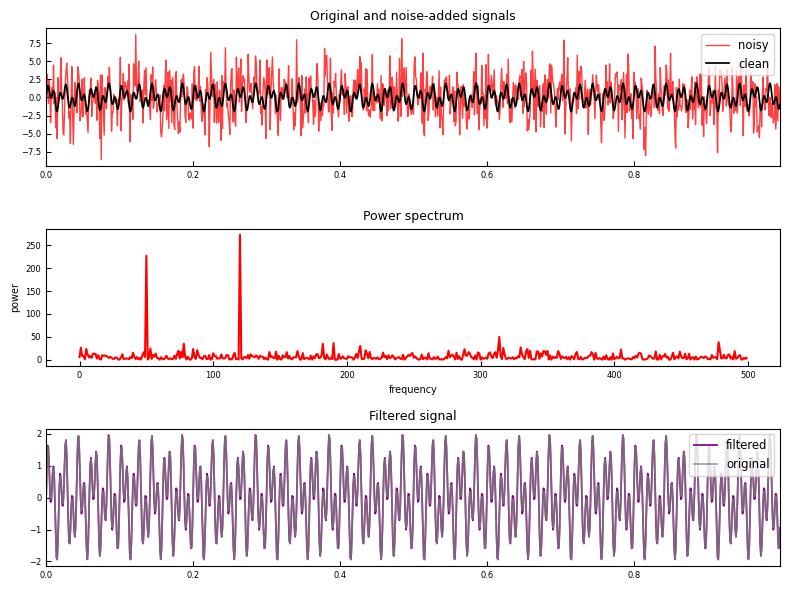

In [20]:
# | fig-cap: Original, power spectrum and filtered signal for generated signal with noise. 
# | fig-alt: Original, power spectrum and filtered signal for generated signal with noise.
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(8, 6), tight_layout=True)
ax[0].set_title("Original and noise-added signals", fontsize=9)
ax[0].plot(t, f, color="red", linewidth=1., alpha=.75, label="noisy")
ax[0].plot(t, forig, color="black", linewidth=1.25, alpha=1, label="clean")
ax[0].set_xlim(t[0], t[-1])
ax[0].legend(fontsize="small", loc="upper right")

ax[1].set_title("Power spectrum", fontsize=9)
ax[1].plot(freq[:n // 2], psd[:n // 2], color="red", linewidth=1.5)
ax[1].set_xlabel("frequency", fontsize=7)
ax[1].set_ylabel("power", fontsize=7)

ax[2].plot(t, ffilt, color="purple", linewidth=1.25, label="filtered")
ax[2].plot(t, forig, color="grey", linewidth=1.25, alpha=.75, label="original")
ax[2].set_title("Filtered signal", fontsize=9)
ax[2].legend(fontsize="small", loc="upper right")
ax[2].set_xlim(t[0], t[-1])

for ii in range(3):
    ax[ii].tick_params(axis="x", which="major", direction='in', labelsize=6)
    ax[ii].tick_params(axis="y", which="major", direction='in', labelsize=6)

plt.show();

This tells us that even though the original signal is noisy, much of the signal is at 50Hz and 120Hz (verified by running `np.where(psd[:n // 2]>thresh)[0]`), or the frequencies with power value in excess of the black horizontal dashed line in the center facet. Overlaying the filtered and original signals in the bottom facet, we see they line up perfectly.


### Filtering an Audio File

In practice, the signal of interest will not be generated from an analytic function. Typically we'll have a signal, and need to identify the dominant frequencies for downstream analysis. In the code that follows, the frequency spectrum is generated for a signal of arbitrary origin, which can be extended to any time domain signal. The signal is filtered, then we approximate the original signal using only a small number of frequencies. The focus will be on an audio clip of a vintage telephone ringer, available [here](https://mixkit.co/free-sound-effects/). 

In [21]:

# Code to read in a .wav file, perform FFT and generate filtered signal.
from scipy.fftpack import fft, fftfreq
from scipy.io.wavfile import read

# Load .wav file. data has dimension nx2, with 2 representing
# the channels. We focus on the first channel only. 
censor = 2**16
fs, data = read("vintage-telephone-ringtone.wav")
s = data[:, 0].astype(float)[:censor]
n = len(s)
t = np.arange(n)
sample_secs = len(s) / fs   # Duration of sample audio clip. 
dt = 1 / fs                 # Time in seconds between samples. 
fhat = fft(s)               # Generate Fourier coefficients.
psd = np.abs(fhat) / n      # Power spectrum.

# x-axis for plotting. Can also call fftfreq(s.shape[0], d=dt).
freq = (1 / (dt * n)) * np.arange(n) 

# Retain frequencies with power above this threshold.
thresh = 500

# Find all freqs with power > thresh. Zero out small Fourier coeffs.
indices = psd > thresh
ffilt = np.fft.ifft(indices * fhat) # Inverse fft for filtered time signal.


We then plot the original signal, power spectrum and filtered signal:

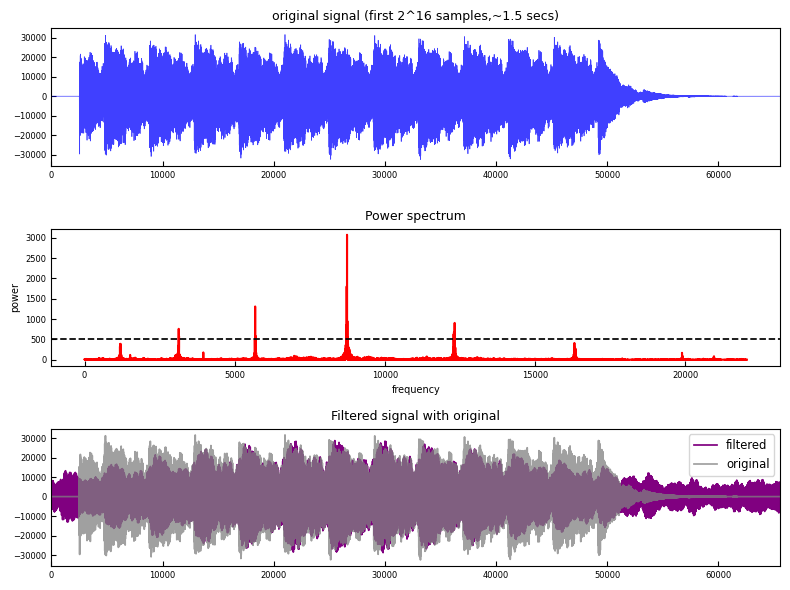

In [23]:
# | fig-cap: Original, power spectrum and filtered signal for audio signal.
# | fig-alt: Original, power spectrum and filtered signal for audio signal.
fig, ax = plt.subplots(3, 1, figsize=(8, 6), tight_layout=True)
ax[0].set_title("original signal (first 2^16 samples,~1.5 secs)", fontsize=9)
ax[0].plot(t, s, color="blue", linewidth=.5, alpha=.75, label="original")
ax[0].set_xlim(t[0], t[-1])

ax[1].set_title("Power spectrum", fontsize=9)
ax[1].plot(freq[:n // 2], psd[:n // 2], color="red", linewidth=1.5)
ax[1].axhline(thresh, color="black", linestyle="--", linewidth=1.25)
ax[1].set_xlabel("frequency", fontsize=7)
ax[1].set_ylabel("power", fontsize=7)

ax[2].set_title("Filtered signal with original", fontsize=9)
ax[2].plot(t, ffilt, color="purple", linewidth=1.25, label="filtered")
ax[2].plot(t, s, color="grey", linewidth=1.25, alpha=.75, label="original")
ax[2].legend(fontsize="small")
ax[2].set_xlim(t[0], t[-1])

for ii in range(3):
    ax[ii].tick_params(axis="x", which="major", direction='in', labelsize=6)
    ax[ii].tick_params(axis="x", which="minor", direction='in', labelsize=6)
    ax[ii].tick_params(axis="y", which="major", direction='in', labelsize=6)
    ax[ii].tick_params(axis="y", which="minor", direction='in', labelsize=6)

plt.show();



We set the threshold to retain only those frequencies with power in excess of 500. In the bottom facet, we see that by retaining only a small number of frequencies, we are able to capture a reasonable approximation to the original signal, especially away from the endpoints. 

The filtered signal can be written to file as follows:

```python
# Optionally export filtered audio.
from scipy.io.wavfile import write
write("filtered-telephone2.wav", fs, np.real(ffilt).astype(np.int16))
```
